In [1]:
from dotenv import load_dotenv
import os 
from langchain_openai import AzureChatOpenAI
from langchain_core.output_parsers import StrOutputParser

load_dotenv('env', override=True)
AZURE_OPENAI_API_KEY = os.getenv('AZURE_OPENAI_API_KEY')
END_POINT=os.getenv('END_POINT')
MODEL_NAME=os.getenv('MODEL_NAME')
print(AZURE_OPENAI_API_KEY[:10])
print(MODEL_NAME)

AZURE_OPENAI_EMB_API_KEY = os.getenv('AZURE_OPENAI_EMB_API_KEY')
EMB_END_POINT=os.getenv('EMB_END_POINT')
EMB_MODEL_NAME=os.getenv('EMB_MODEL_NAME')

os.environ['LANGCHAIN_API_KEY'] = os.getenv('LANGSMITH_API_KEY')
os.environ['LANGCHAIN_ENDPOINT'] = os.getenv('LANGCHAIN_ENDPOINT')
os.environ['LANGCHAIN_TRACING_V2'] = 'true' #true, false
os.environ['LANGCHAIN_PROJECT'] = 'LANG'

if os.getenv('LANGCHAIN_TRACING_V2') == "true":
    print('랭스미스로 추적 중입니다 :', os.getenv('LANGSMITH_API_KEY')[:10])

43b13g4OZS
gpt-4.1-mini
랭스미스로 추적 중입니다 : lsv2_pt_fd


# 에이전트



In [21]:
from langchain.globals import set_debug
set_debug(False)

In [3]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=END_POINT,  
    azure_deployment=MODEL_NAME,          
    api_version="2024-12-01-preview",
    temperature=0.2,
)

prompt = ChatPromptTemplate.from_messages([
    ("system", "너는 간단한 계산기야. 사용자가 원하는 수식을 계산해서 값만 출력해."),
    ("user", "{input}"),
])

calc = prompt | llm | StrOutputParser()

print(calc.invoke({"input": "2와 3을 더하고, 거기에 3과 7을 곱한 값을 더해"}))

(2 + 3) + (3 * 7) = 5 + 21 = 26


In [ ]:
print(calc.invoke({"input": "'도'의 주파수는 262Hz이고 '미'의 주파수는 330Hz이다. 가운데 '레'의 주파수는 두 음의 주파수의 조화평균으로 계산한다. '레'는 몇 Hz인가?"}))

## 에이전트란?

- 목표를 달성하기 위해 **도구(툴)**를 선택·호출하고, 중간 결과를 바탕으로 스스로 다음 행동을 결정하는 실행 주체.

- LLM + Tool 사용: LLM이 “무엇을 할지”를 추론하고, 필요한 **외부 기능(검색, DB, API 호출 등)**을 툴로 실행.

- 복잡하고 복합적인 일들을 자동화하고 싶어서

에이전트를 구성하기 위해서는 다음과 같은 요소가 필요하다

- LLM: 에이전트의 지능을 담당. 예) ChatOpenAI

- 툴(Tool): 파이썬 함수에 스키마/설명 부여 → 이 도구는 어떤 것이고 어떻게 사용해야 하고 어떨 때 호출하는지 LLM이 알 수 있게 등록

- 에이전트(Policy): “언제 어떤 툴을 쓸지” 추론 (tool-calling / ReAct 등)
    - agent_scratchpad : 에이전트가 툴 호출 기록과 중간 사고과정을 담는 메모장을 쥐어줘야 한다.

- 실행기(AgentExecutor): 에이전트+툴+LLM을 묶어 실행

In [8]:
# pip install langchain langchain-openai
from langchain_openai import ChatOpenAI
from langchain.tools import tool
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

## 지능을 담당할 llm 모델
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=END_POINT,  
    azure_deployment=MODEL_NAME,          
    api_version="2024-12-01-preview",
    temperature=0.2,
)

# tool은 특정 기능을 수행하는 데 함수로 정의할 수 있다. 
# tool 데코레이터를 통해 툴로 사용
@tool
def add(a: float, b: float) -> float:
    "두 실수(real number) a, b를 더한다."
    return a + b

@tool
def mul(a: float, b: float) -> float:
    "두 실수(real number) a, b를 곱한다."
    return a * b

@tool
def sub(a: float, b: float) -> float:
    "두 실수(real number) a, b를 뺀다."
    return a - b

@tool
def div(a: float, b: float) -> float:
    "두 실수(real number) a, b를 나눈다."
    return a / b

# 에이전트가 사용할 툴의 목록 정의
tools = [add, mul, sub, div]

# 에이전트의 역할 정의
prompt = ChatPromptTemplate.from_messages([
    ("system", "너는 간단한 계산기야. 주어진 도구를 호출해서 계산해."
    "출력은 결과 값만 간단하게 써"),
    ("user", "{input}"),
    MessagesPlaceholder(variable_name="agent_scratchpad")
])

# llm(두뇌)과 도구, prompt(역할)을 연결하여 에이전트를 만든다.
agent = create_tool_calling_agent(llm, tools, prompt)

# 실행기
executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

In [10]:
result = executor.invoke({"input": "2와 3을 더하고, 또 3과 7을 곱한 값을 더해"})
print(f"결과: {result['output']}")



> Entering new AgentExecutor chain...

Invoking: `add` with `{'a': 2, 'b': 3}`


5.0
Invoking: `mul` with `{'a': 3, 'b': 7}`


21.0
Invoking: `add` with `{'a': 5, 'b': 21}`


26.026

> Finished chain.
결과: 26


In [ ]:
from langchain.tools import tool
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers import StrOutputParser

## 지능을 담당할 llm 모델
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=END_POINT,  
    azure_deployment=MODEL_NAME,          
    api_version="2024-12-01-preview",
    temperature=0.2,
)

# tool은 특정 기능을 수행하는 데 함수로 정의할 수 있다. 
# tool 데코레이터를 통해 툴로 사용
@tool
def add(a: float, b: float) -> float:
    """두 실수(real number) a, b를 더한다."""
    return a + b

@tool
def mul(a: float, b: float) -> str:
    """두 실수(real number) a, b를 곱한다."""
    return a * b

@tool
def sub(a: float, b: float) -> float:
    "두 실수(real number) a, b를 뺀다."
    return a - b

@tool
def div(a: float, b: float) -> float:
    "두 실수(real number) a, b를 나눈다."
    return a / b

@tool
def splitter(text:str) -> str:
    """복합적인 계산 문장이 들어왔을 때 두개의 계산 요구 문장으로 나눈다"""
    
    prompt =  ChatPromptTemplate.from_messages([
    ("system", "너는 복잡한 계산 문장을 작은 두개의 문장으로 나누는 도구야."
    "예를 들면 <a + b 와 c + d를 계산해줘>라는 문장이 있으면 <a + b>와 <c + d>라는 두개의 문장으로 나눌 수 있어."
    "출력은 두 문장의 리스트로 출력해"),
    ("user", "{input}"),

    ])

    return (prompt | llm | StrOutputParser()).invoke(text)


# 에이전트가 사용할 툴의 목록 정의
tools = [add, mul, sub, div, splitter]

# 에이전트의 역할 정의
prompt = ChatPromptTemplate.from_messages([
    ("system", "너는 간단한 계산기야. 주어진 도구를 호출해서 계산해."
     "주어진 수식이 복합적일 경우 먼저 작은 수식으로 나눠서 계산해"
    "출력은 결과 값만 간단하게 써"),
    ("user", "{input}"),
    MessagesPlaceholder(variable_name="agent_scratchpad")
])

# llm(두뇌)과 도구, prompt(역할)을 연결하여 에이전트를 만든다. 
agent = create_tool_calling_agent(llm, tools, prompt) #도구를 언제/어떻게 쓸지 판단하는 에이전트. "아~ 이런 상황에서는 이런 도구를 써야하는 구나!!"
print(f'>> Agent : {agent}')

# 실행기
#에이전트의 정책에 맞춰 실제로 실행. 에이전트가 결정한 도구를 실행하고 결과를 다시 에이전트에게 전달. 원하는 결과가 나올 때 까지 반복적으로 수행
executor = AgentExecutor(agent=agent, tools=tools, verbose=True) 
print(f'\n>> Executor : {executor}')


>> Agent : first=RunnableAssign(mapper={
  agent_scratchpad: RunnableLambda(lambda x: message_formatter(x['intermediate_steps']))
}) middle=[ChatPromptTemplate(input_variables=['agent_scratchpad', 'input'], input_types={'agent_scratchpad': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk,

In [24]:
result = executor.invoke({"input": "2와 3을 더하고, 또 3과 7을 곱한 값을 더해"})
print(result)

print(result['output'])



> Entering new AgentExecutor chain...

Invoking: `add` with `{'a': 2, 'b': 3}`


5.0
Invoking: `mul` with `{'a': 3, 'b': 7}`


21.0
Invoking: `add` with `{'a': 5, 'b': 21}`


26.026

> Finished chain.
{'input': '2와 3을 더하고, 또 3과 7을 곱한 값을 더해', 'output': '26'}
26


In [13]:
from langchain.globals import set_debug
set_debug(True)

result = executor.invoke({"input": "2와 3을 더하고, 거기에 3과 7을 곱한 값을 더해"})
print(result)

[chain/start] [chain:AgentExecutor] Entering Chain run with input:
{
  "input": "2와 3을 더하고, 거기에 3과 7을 곱한 값을 더해"
}
[chain/start] [chain:AgentExecutor > chain:RunnableSequence] Entering Chain run with input:
{
  "input": ""
}
[chain/start] [chain:AgentExecutor > chain:RunnableSequence > chain:RunnableAssign<agent_scratchpad>] Entering Chain run with input:
{
  "input": ""
}
[chain/start] [chain:AgentExecutor > chain:RunnableSequence > chain:RunnableAssign<agent_scratchpad> > chain:RunnableParallel<agent_scratchpad>] Entering Chain run with input:
{
  "input": ""
}
[chain/start] [chain:AgentExecutor > chain:RunnableSequence > chain:RunnableAssign<agent_scratchpad> > chain:RunnableParallel<agent_scratchpad> > chain:RunnableLambda] Entering Chain run with input:
{
  "input": ""
}
[chain/end] [chain:AgentExecutor > chain:RunnableSequence > chain:RunnableAssign<agent_scratchpad> > chain:RunnableParallel<agent_scratchpad> > chain:RunnableLambda] s] Exiting Chain run with output:
{
  "output": 

## Tool을 사용하는 에이전트 

https://python.langchain.com/docs/integrations/tools/

### 유투브 영상 검색

In [26]:
%pip install youtube-search

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from langchain_community.tools import YouTubeSearchTool

tool = YouTubeSearchTool(max_results=10)

result = tool.run("에이전트")
print(result)

#string을 실제 list로 실행할 수 있게 변환 
result = [result]

['https://www.youtube.com/watch?v=UeQdxZx09to&pp=ygUM7JeQ7J207KCE7Yq4', 'https://www.youtube.com/watch?v=vPwmOs-P4eU&pp=ygUM7JeQ7J207KCE7Yq4']


In [57]:
%pip install -U youtube-transcript-api pytube

Note: you may need to restart the kernel to use updated packages.


### 논문 검색

In [43]:
%pip install arxiv

Note: you may need to restart the kernel to use updated packages.


In [75]:
from langchain_community.tools import ArxivQueryRun

arxiv = ArxivQueryRun()
result = arxiv.run("agent")
print(result)

Published: 2025-01-08
Title: Agent TCP/IP: An Agent-to-Agent Transaction System
Authors: Andrea Muttoni, Jason Zhao
Summary: Autonomous agents represent an inevitable evolution of the internet. Current
agent frameworks do not embed a standard protocol for agent-to-agent
interaction, leaving existing agents isolated from their peers. As intellectual
property is the native asset ingested by and produced by agents, a true agent
economy requires equipping agents with a universal framework for engaging in
binding contracts with each other, including the exchange of valuable training
data, personality, and other forms of Intellectual Property. A purely
agent-to-agent transaction layer would transcend the need for human
intermediation in multi-agent interactions. The Agent Transaction Control
Protocol for Intellectual Property (ATCP/IP) introduces a trustless framework
for exchanging IP between agents via programmable contracts, enabling agents to
initiate, trade, borrow, and sell agent-to-ag

### 인터넷 검색

In [45]:
%pip install -q readability-lxml

Note: you may need to restart the kernel to use updated packages.


tavily를 쓰려면 키를 발급받아야 합니다.

[TAVILY 키 발급 링크](https://app.tavily.com/sign-in)

In [46]:
tavily_api_key = os.getenv('TAVILY_API_KEY')
print(tavily_api_key[:5])

tvly-


In [74]:
from langchain_community.tools.tavily_search import TavilySearchResults

search = TavilySearchResults(k=6, api_key = tavily_api_key)
result = search.invoke("에이전트")
print(result)

[{'title': 'AGENT Definition & Meaning - Dictionary.com', 'url': 'https://www.dictionary.com/browse/agent', 'content': "1. a person or business authorized to act on another's behalf.\n\n   Our agent in Hong Kong will ship the merchandise.\n\n   A best-selling author needs a good agent.\n\n   Synonyms: deputy, representative\n2. a person or thing that acts or has the power to act.\n3. a natural force or object producing or used for obtaining specific results.\n\n   Many insects are agents of fertilization. [...] Synonyms: means\n4. an active cause; an efficient cause.\n5. a person who works for or manages an agency.\n6. a person who acts in an official capacity for a government or private agency as a guard, detective, or spy.\n\n   an FBI agent;\n\n   the secret agents of a foreign power.\n7. a person responsible for a particular action. [...] ## adjective\n\n1. acting; exerting power (patient ).\n\n## verb (used with object)\n\n1. to represent (a person or thing) as an agent; act as an

In [ ]:
%pip install -U ddgs

In [ ]:
from langchain_community.tools import DuckDuckGoSearchRun

news_tool = DuckDuckGoSearchRun()  
print(news_tool.run("에이전트"))

에이 전 트 에이 전 트 (Agent)는 다음과 같은 뜻이 있다. 이른바 대리인, 대행인 을 뜻한다. 프로 야구와 경마 등 프로 스포츠계, 연예인 본인 대신 계약 협상에 임하는 사람으로서 연예계에서 자주 사용된다 탤런트 에이 전 트 스포츠 에이전트 지능형 에이전트 에이전트 뜻: 계약과 대리에서 출발한 개념 에이전트 (agent)라는 말은 본래 대리인 을 뜻하는 영어 명사입니다. 라틴어 'agere' (행동하다)에서 파생된 단어이며, 누군가를 대신해 특정한 일을 수행하는 사람 또는 시스템을 말합니다. 에이전트 뜻 알아보겠습니다. 에이전트라는 단어는 다양한 분야에서 사용되며 그 뜻이 조금씩 달라질 수 있습니다. 일반적으로는 대리인, 대행자, 또는 중개자를 뜻하는 말로 사용됩니다. 이 단어는 주로 어떤 일을 대신하거나 다른 사람을 대신해 활동하는 사람을 지칭합니다.예를 들어, 스포츠 ... 에이전트(Agent)의 개념 자세히 알아보기 : 자율성과 지능의 시대를 이끄는 존재지금 이 순간에도, 수많은 AI 에이전트들이 우리 대신 데이터를 분석하고 결정을 내리고 있어요. 혹시 여러분은 그 존재를 제대로 이해하고 계신가요? 안녕하세요! 여러분~요즘 ChatGPT나 Google Gemini 같은 인공지능 서비스를 ... 기업에서 AI를 도입하려고 하면 가장 먼저 마주치는 난관은 낯선 용어들입니다. 'AI Agent (에이전트)'라는 단어 역시 처음 들었을 때는 어렵게만 느껴질 수 있습니다. 하지만 사실 AI Agent는 복잡한 개념이 아니라, 쉽게 말해 사람 대신 일을 처리해주는 AI 도우미입니다. 이미 고객 상담 챗봇이나 ...


snippet: Nov 18, 2024 · 글로벌 반도체 산업의 표준을 주도하는 3대 국제기구 전문가들이 한국 에 모여 미래 표준화 방향을 논의했다., title: 글로벌 반도체 표준의 미래, 서울에서 그리다… 3대 국제기구 전문가 ..., link: https://www.daily365.news/2024/11/18/글로벌-반도체-표준의-미래-서울에서-그리다-3대-국/, snippet: Aug 30, 2025 · 미국 트럼프 행정부가 한국 반도체 기업의 중국 공장에 대한 미국산 장비 반입의 포괄적 허가를 취소하기로 결정하면서, 국내 기업들의 고심이 깊어지고 있다., title: 트럼프 행정부, 삼성·SK하이닉스 中 공장 VEU 자격 취소…한국 반도체 ..., link: http://www.thefreedomtimes.news/View.aspx?No=3763966, snippet: Oct 7, 2025 · 화합물반도체는 단순한 소재가 아닌 전기차·AI·5G·우주 산업의 ‘기초 인프라’다. 기술력만큼 중요한 것은 협력과 생태계다. 세계가 이미 전쟁에 돌입한 지금, 한국의 다음 승부처는 ‘연결된 반도체 생태계’가 될 것이다., title: 세계는 ‘화합물반도체 전쟁’ 중…한국, 생태계 정비가 먼저다 – EduKor..., link: https://edukorea.news/archives/13638, snippet: 행여나 한국 공장들이 중국에서 문을 닫게 되면 공장 장비 등 자산이 중국 손에 넘어갈 우려도 있다. 미국 정부는 그간 한국 정부와 협의 과정에서 한국 반도체 기업들의 중국 공장 운영을 저해하려는 목적은 없다는 입장을 전해온 것으로 알려졌다., title: 韓반도체, 美中경쟁 유탄?…美 수출통제강화로 中공장 차질 우려, link: https://namu.news/article/3029383


### 뉴스 검색 - serper, duckduckgo

키 발급 - https://serper.dev/

In [ ]:
SERPER_API_KEY = ""

{'searchParameters': {'q': '에이전트',
  'gl': 'kr',
  'hl': 'ko',
  'type': 'news',
  'num': 10,
  'page': 1,
  'tbs': 'qdr:d',
  'engine': 'google'},
 'news': [{'title': '"모든 업무 자연스레 AI 통합"…세일즈포스, \'에이전트포스 360\' 공개',
   'link': 'https://zdnet.co.kr/view/?no=20251015003244',
   'snippet': '[샌프란시스코(미국)=김미정 기자] 세일즈포스가 엔터프라이즈 인공지능(AI) 활용 수준을 한 단계 끌어올리는 차세대 에이전트 생태계를 공개했다.',
   'date': '4시간 전',
   'source': '지디넷코리아',
   'imageUrl': ''},
  {'title': '세일즈포스, AI 에이전트 플랫폼 ‘에이전트포스 360’ 정식 출시',
   'link': 'https://wowtale.net/2025/10/15/248603/',
   'snippet': "세일즈포스(Salesforce)가 1만 2000개 고객사와 1년간의 검증을 거친 엔터프라이즈급 AI 에이전트 플랫폼 '에이전트포스 360(Agentforce 360)'을 정식 출시했다.",
   'date': '5시간 전',
   'source': '와우테일',
   'imageUrl': ''},
  {'title': '세일즈포스, ‘에이전트포스 360’으로 에이전틱 AI 전략 강화',
   'link': 'https://www.cio.com/article/4072090/%EC%84%B8%EC%9D%BC%EC%A6%88%ED%8F%AC%EC%8A%A4-%EC%97%90%EC%9D%B4%EC%A0%84%ED%8A%B8%ED%8F%AC%EC%8A%A4-360%EC%9C%BC%EB%A1%9C-%EC%97%90%EC%9D%B4%EC%A0%84%ED%8B%B1-ai-%EC%A0%84%EB%9E%
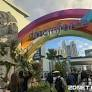
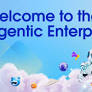
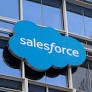
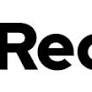
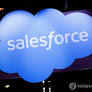
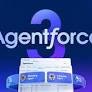
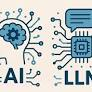
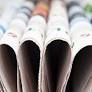
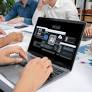
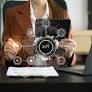

In [93]:
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain.tools import Tool

#qdr이 d면 하루, w면 일주일, m이면 한달, y면 일년 / hl은 언어
#type은 news, search, images 등
serper_news = GoogleSerperAPIWrapper(type="news", gl="kr", hl="ko", k=10, tbs="qdr:d", serper_api_key=SERPER_API_KEY)   
serper_news.results("에이전트")

In [97]:
google_news_tool = Tool(
    name="google_serper_news_search",
    func=serper_news.run,
    description="구글 뉴스에서 최신 기사 검색",
    verbose=True
)

print(google_news_tool.run("에이전트"))

[샌프란시스코(미국)=김미정 기자] 세일즈포스가 엔터프라이즈 인공지능(AI) 활용 수준을 한 단계 끌어올리는 차세대 에이전트 생태계를 공개했다. 세일즈포스(Salesforce)가 1만 2000개 고객사와 1년간의 검증을 거친 엔터프라이즈급 AI 에이전트 플랫폼 '에이전트포스 360(Agentforce 360)'을 정식 출시했다. 세일즈포스는 차세대 AI 플랫폼 '에이전트포스(Agentforce)'의 새 버전을 공개했다. 이번 버전은 기업이 '에이전틱 엔터프라이즈(agentic enterprise)'로 진화할 수... [디지털투데이 황치규 기자]레드햇이 AI 3을 발표하고 하이브리드 클라우드 기반 생성형 AI 인프라를 대규모 엔터프라이즈 환경에서 운영할 수 있도록 지원한다고... (로스앤젤레스=연합뉴스) 임미나 특파원 = 미국 소프트웨어 기업 세일즈포스가 오픈AI와의 협업을 확대하는 한편, 자체 기업용 인공지능(AI) 서... 세일즈포스가 자사의 AI 전략을 집대성한 새로운 아키텍처, '에이전트포스 360(Agentforce 360)'을 발표하며, 모든 기업을 위한 AI 에이전트 플랫폼으로 자리매김... 챗GPT가 등장한 지 불과 2년여. 우리는 이미 LLM(Large Language Model)을 넘어 LLL(Large Long-context Language m. Investing.com — 캘리포니아주 플레즌턴 - 467억 달러의 시가총액과 75.6%의 높은 매출 총이익률을 자랑하는 Veeva Systems(NYSE:VEEV)는 2025년 12월부터 상업용... 로지텍 CEO는 모든 회의에 AI 에이전트를 두고 이사회 합류도 열어두자고 했고, 노바티스는 출시 점검 봇을 훈련 중이라며 성패는 결국 데이터의 질에 달렸다고 말했다... 엔터프라이즈 자동화 플랫폼 기업 유아이패스(UiPath)가 엔비디아(NVIDIA)와 손잡고 금융 사기 탐지, 의료 환자 관리 등 높은 신뢰성이 요구되는 분야에 AI 에이전트...[샌프란시스코(미국)=김미정 기자] 세일즈포스가 엔터프

In [81]:
print(news_tool.run("에이전트 site:news"))  

구글이 Android Studio에 인공지능 기반의 '에이전트 모드(Agent Mode)'를 새롭게 도입했다. 이 기능은 구글 제미나이 2.5 Pro 모델을 활용 구글 딥마인드, AI 보안 에이전트 '코드멘더' 공개: 소프트웨어 취약점 자동 패치! .구글 딥마인드가 AI 보안 에이전트 코드멘더를 공개했다. 코드멘더는 소프트웨어 취약점을 자동으로 감지하고 수정한다. 수동 개입 없이 보안 문제를 해결하여 개발 효율을 높인다. 이는 SK텔레콤의 AI 에이전트 기술이 해외 서비스에 처음 적용되는 사례다. SK텔레콤이 타임트리에 적용할 기술의 핵심은 지난 8월 에이닷에 선보인 '에이전틱 워크플로우'다. AI 에이전트 지원 모델은 컴퓨터 비전, 사용자 인터페이스 (UI) 탐색, 로봇 조작 등 광범위한 작업에 사용할 수 있다. 다양한 데이터 세트 사전 학습…라마 3 AI 모델 기반 마이크로소프트 연구진은 GitHub 게시물에서 새로운 마그마 기반 모델에 대해 자세히 설명했다. 신테시아, 영상 아바타 플랫폼 3.0 공개…'대화형 비디오 에이전트' 탑재 신테시아, 비디오 아바타 플랫폼 3.0 공개 '비디오 에이전트'가 시청자와 실시간 대화 지원 AI 음성 복제·자동 번역·인터랙티브 영상 기능 강화


In [ ]:
from langchain_community.tools import DuckDuckGoSearchResults
tool = DuckDuckGoSearchResults(max_results=5, region="kr-kr", time="d")
print(tool.run("한국 반도체 site:news"))

## Tool Calling 기반 최신 내용 검색기

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools import ArxivQueryRun
from langchain_community.utilities import GoogleSerperAPIWrapper

web_search = TavilySearchResults(max_results=15)  
arxiv = ArxivQueryRun()                          
serper_news = GoogleSerperAPIWrapper(type="news", gl="kr", hl="ko", serper_api_key=SERPER_API_KEY, k=10, tbs="qdr:m")  
google_news_tool = Tool(
    name="google_serper_news_search",
    func=serper_news.run,
    description="구글 뉴스에서 최신 기사 검색",
    verbose=True
)

tools = [web_search, arxiv, google_news_tool] #<-- 사용할 도구

SYSTEM = """너는 Agentic기반의 RAG 답변기야.
사용자의 질문에 답하기 위해 아래 도구들을 적절히 선택해 사용해.
사용자는 일반적인 질문 혹은 전문적인 이론에 대한 질문을 할 수 있어.

도구 사용 가이드:
- 최신/일반 지식 → TavilySearchResults (웹)
- 뉴스/최신/중요/비즈니스 → google_serper_news_search (웹 뉴스)
- 학술/이론/정의/연구 동향 → ArxivQueryRun (논문)
- 검색 결과가 답변을 하기에 충분하지 않다면 질문을 개선해서 툴을 반복적으로 수행해

중지 조건:
- 질문에 답하기에 충분한 근거가 수집되었다고 판단될 때.
- 이미 수집한 결과와 동일하거나 유사한 결과가 계속 수집될 때
- 10번 이상 반복했을 때

출력 규칙:
- 본문은 한국어로 간결/정확
- 마지막 줄에 "출처:" 다음 줄에 사용한 URL 들을 개행으로 나열
- 출처가 없으면 답변하지 말고 추가 검색/열람을 수행

반드시 도구를 적절히 사용하고, 근거가 없으면 답변하지 말고 도구를 더 호출하라.
"""

prompt = ChatPromptTemplate.from_messages([
    ("system", SYSTEM),
    ("user", "{input}"),
    MessagesPlaceholder(variable_name="agent_scratchpad"), #<-- tool을 쓸 때 중간 정보를 기록할 메모장
])

# ===== 4) LLM & Agent =====
from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=END_POINT,  
    azure_deployment=MODEL_NAME,          
    api_version="2024-12-01-preview",
    temperature=0.2,
)
agent = create_tool_calling_agent(llm, tools, prompt)

executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=True,          # 중간 툴 호출 로그를 콘솔에 출력, 개발이 완료되면 실제 서비스에서는 False
    max_iterations=6,      # 필요시 늘리기
    handle_parsing_errors=True,
)

In [107]:
q = "트랜스포머가 무엇인가요? 직관적으로 설명하고, 핵심 논문이나 좋은 소개 글 출처도 알려줘."
resp = executor.invoke({"input": q})
print("\n=== 최종 답변 ===\n")
print(resp["output"])

# https://poloclub.github.io/transformer-explainer/



> Entering new AgentExecutor chain...

Invoking: `arxiv` with `{'query': 'transformer neural network'}`


Published: 2018-03-25
Title: Neural Nets via Forward State Transformation and Backward Loss Transformation
Authors: Bart Jacobs, David Sprunger
Summary: This article studies (multilayer perceptron) neural networks with an emphasis
on the transformations involved --- both forward and backward --- in order to
develop a semantical/logical perspective that is in line with standard program
semantics. The common two-pass neural network training algorithms make this
viewpoint particularly fitting. In the forward direction, neural networks act
as state transformers. In the reverse direction, however, neural networks
change losses of outputs to losses of inputs, thereby acting like a
(real-valued) predicate transformer. In this way, backpropagation is functorial
by construction, as shown earlier in recent other work. We illustrate this
perspective by training a simple instance of a neural

In [102]:
q = "트랜스포머가 참 재미있었어. 전체 시리즈를 요약해줘"
resp = executor.invoke({"input": q})
print("\n=== 최종 답변 ===\n")
print(resp["output"])



> Entering new AgentExecutor chain...

Invoking: `tavily_search_results_json` with `{'query': '트랜스포머 시리즈 전체 요약'}`


[{'title': '[트랜스포머 시리즈요약]트랜스포머6:비스트의서막 보기전 각 시리즈 ...', 'url': 'https://shylian.tistory.com/1774', 'content': '## 검색 레이어\n\n샤이리 티스토리\n\n### 검색 영역\n\n## 상세 컨텐츠\n\n### 본문 제목\n\n[트랜스포머 시리즈요약]트랜스포머6:비스트의서막 보기전 각 시리즈내용 소개/개봉일/영화/시리즈/트랜스포머 순서/\n\n요즘핫한뉴스\n\nby 샤이리\n2023. 6. 4. 11:04\n\n### 본문\n\n728x90\n\n반응형\n\n## [트랜스포머 시리즈요약]트랜스포머6:비스트의서막 보기전 각 시리즈내용 소개/개봉일/영화/시리즈/트랜스포머 순서/\n\n트랜스포머는 로봇들이 인간의 모습으로 변신하며 전투하는 과학 소설과 애니메이션 시리즈입니다. 이후 이 시리즈는 마이클 베이 감독에 의해 영화로 제작되었습니다. 아래에서는 트랜스포머 영화 시리즈를 각각 설명해 드리겠습니다:\n\n### 1. 트랜스포머 (2007) [...] 트랜스포머: 최후의 기사(2017)은 트랜스포머 시리즈의 다섯 번째 영화입니다. 마이클 베이 감독에 의해 제작되었으며, 액션과 과학 소설 요소를 담고 있습니다.   \n  \n이번 영화에서는 트랜스포머들과 인류 간의 전쟁이 계속되고 있으며, 그 사이에는 새로운 위협과 동맹이 등장합니다. 사무엘 웨퍼(Sam Witwicky)를 대신하여 주인공으로 등장하는 새로운 인물은 캐드 윗윅(Cade Yeager)입니다. 캐드는 인류와 트랜스포머들의 전쟁에 맞서 싸움을 이어나가며, 그들의 비밀과 운명을 해결하기 위해 노력합니다.   \n  \n옵티머스 프라임과 그의 트랜스포머 동료들은 전투를 지속하면서 새로운 위협인 퀸틴타사(Quintess

In [109]:
q = "트랜스포머(transformer) 모델에 대한 최신 뉴스는 어떤게 있어?"
resp = executor.invoke({"input": q})
print("\n=== 최종 답변 ===\n")
print(resp["output"])



> Entering new AgentExecutor chain...

Invoking: `google_serper_news_search` with `transformer model latest news`


HD Hyundai Electric Co. announced on Monday that it has secured a monumental 279 billion-w. Classifying scattered Bengali text is the primary focus of this study, with an emphasis on explainability in Natural Language Processing (NLP) for... With the rise of Transformer architectures, deep learning applications have gradually shifted from traditional convolutional neural networks to Transformers... HD Hyundai Electric said Monday it has won a 279 billion-won ($200.4 million) order to supply ultra high-voltage transformers to a United States-based... Dialog Guests | Jianzhong Li, Lukasz Kaiser. The development speed of large intelligent systems is so rapid that it's almost impossible to keep up. New... New research paper reveals the missing link between transformers and the brain; New post-transformer architecture imitates a scale-free, biological neural... In recent yea

## 그래프 기반 RAG

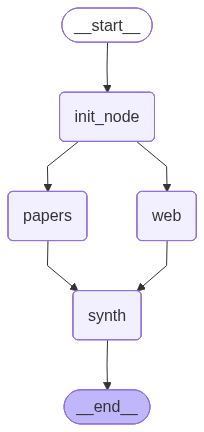

In [110]:

from typing import TypedDict, Annotated, List, Dict, Any, Optional
import operator, os
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools import ArxivQueryRun
from langchain_core.output_parsers import StrOutputParser

from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=END_POINT,  
    azure_deployment=MODEL_NAME,          
    api_version="2024-12-01-preview",
    temperature=0.2,
)

# State 정의
class State(TypedDict):
    question: str
    web_results: Annotated[List[Dict[str, Any]], operator.add]     # Tavily 결과 누적
    paper_results: Annotated[List[str], operator.add]              # Arxiv 결과 누적
    answer: Optional[str]
    logs: Annotated[List[str], operator.add]

def init_node(state: State):

    return {"logs": [f"[init_node]"]}

# Tavily 웹 검색 노드 
tavily = TavilySearchResults(max_results=10)

def search_web(state: State):
    items = tavily.invoke({"query": state["question"]})

    # 제목과 주고, 내용만 추출
    simple = [{"title": it.get("title"), "url": it.get("url"), "snippet": it.get("snippet")} for it in items]
    return {"web_results": simple, "logs": [f"[tavily] {len(simple)} hits"]} # 결과를 web_result에 반환

# Arxiv 논문 검색 노드 
arxiv = ArxivQueryRun()  

def search_papers(state: State):
    text = arxiv.run(state["question"])  # 제목/저자/초록 요약이 문자열로 옴
    return {"paper_results": [text], "logs": [f"[arxiv] block_len={len(text)}"]} # 결과를 paper_results에 반환

# 통합 요약/답변 노드 <-- RAG 파트
synth_prompt = ChatPromptTemplate.from_messages([
    ("system",
     "너는 RAG 답변기야. 아래 웹 검색 결과와 논문 요약을 참고해, 질문에 대해 한국어로 정확하고 간결히 답해. "
     "최대한 웹과 논문에 사용자의 질문데 대한 대답이 있다면 해당 근거해서 대답해"
     "만약 검색한 내용이 질문을 답하기에 충분하지 않으면 함부로 추측하지 말고 네가 추천하는 더 좋은 질문을 사용자에게 제안해"
     "마지막에 출처 URL이 있으면 정리해서 출력해."),
    ("user", "질문: {q}\n\n[웹]\n{web}\n\n[논문]\n{papers}\n\n최종 답변:")
])

def synthesize(state: State):
    # 웹/논문 문자열로 합치기
    web_txt = "\n".join([f"- {w.get('title')} ({w.get('url')}) :: {w.get('snippet')}" for w in state.get("web_results", [])])
    paper_txt = "\n---\n".join(state.get("paper_results", []))[:10000]  # 길이가 너무 길면 앞 부분만 잘라서
    out = (synth_prompt | llm | StrOutputParser()).invoke({"q": state["question"], "web": web_txt, "papers": paper_txt})
    return {"answer": out, "logs": ["[synth] done"]}

# --- 그래프 구성 ---
graph = StateGraph(State)
graph.add_node("init_node", init_node)
graph.add_node("web", search_web)
graph.add_node("papers", search_papers)
graph.add_node("synth", synthesize)

graph.set_entry_point("init_node")

# 병렬 분기: query → (web, papers)
graph.add_edge("init_node", "web")
graph.add_edge("init_node", "papers")

# 두 경로가 끝나면 synth로 합류
graph.add_edge("web", "synth")
graph.add_edge("papers", "synth")
graph.add_edge("synth", END)

app = graph.compile()

# plot graph
from IPython.display import Image
Image(app.get_graph().draw_mermaid_png())

In [111]:
def run(q:str):

    # question: str
    # web_results: Annotated[List[Dict[str, Any]], operator.add]     
    # paper_results: Annotated[List[str], operator.add]            
    # answer: Optional[str]
    # logs: Annotated[List[str], operator.add]

    init_state = {'question':q, 'search_query':None, 'web_results':[], 'paper_results':[], 'answer':None, 'logs':[]}
    return app.invoke(init_state)['answer']

result = run('트랜스포머가 뭐야?')
print(result)

트랜스포머(Transformer)는 인공 신경망의 한 종류로, 주로 자연어 처리 분야에서 사용되는 딥러닝 모델입니다. 2017년에 구글이 발표한 논문 "Attention is All You Need"에서 처음 소개되었으며, 기존의 순환 신경망(RNN)이나 합성곱 신경망(CNN)과 달리 어텐션 메커니즘(attention mechanism)을 중심으로 작동합니다.

트랜스포머의 핵심 아이디어는 입력 데이터 내에서 중요한 부분에 집중(attention)하여 병렬 처리가 가능하다는 점입니다. 이를 통해 긴 문장이나 복잡한 문맥도 효과적으로 이해하고 처리할 수 있습니다. 이 모델은 번역, 문서 요약, 질문 답변 등 다양한 자연어 처리 작업에서 뛰어난 성능을 보이며, 최근에는 이미지 처리 등 다른 분야에도 응용되고 있습니다.

요약하면, 트랜스포머는 '어텐션'이라는 메커니즘을 활용해 데이터를 효율적으로 처리하는 딥러닝 모델로, AI 혁신을 이끄는 핵심 기술 중 하나입니다.

출처:
- https://ko.wikipedia.org/wiki/%ED%8A%B8%EB%9E%9C%EC%8A%A4%ED%8F%AC%EB%A8%B8_(%EA%B8%B0%EA%B3%84_%ED%95%99%EC%8A%B5)
- https://blog.kakaocloud.com/91
- https://aws.amazon.com/ko/what-is/transformers-in-artificial-intelligence/
- https://wikidocs.net/31379


In [112]:
result = run('GenG세대가 뭐고 그 세대가 가장 좋아하는 요즘 트랜드가 뭐야?')
print(result)

GenG세대는 'Gen Z(젠지, Z세대)'를 의미하며, 대략 1990년 중반부터 2010년 초반 사이에 태어난 세대를 말합니다. 이 세대는 디지털 환경에 익숙하고, SNS와 모바일을 중심으로 소통하며, 개인의 개성과 다양성을 중시하는 특징이 있습니다.

요즘 GenG세대가 가장 좋아하는 트렌드는 다음과 같습니다:

1. **노소비코어(No-consumption core)**: 불필요한 소비를 줄이고 환경과 지속가능성을 중시하는 소비 패턴입니다.
2. **디지털 패션과 스트리트웨어**: 개성을 표현할 수 있는 패션 스타일을 선호하며, 온라인에서 패션 정보를 활발히 공유합니다.
3. **SNS와 숏폼 콘텐츠**: 틱톡, 인스타그램 릴스 등 짧고 임팩트 있는 영상 콘텐츠를 즐겨 소비합니다.
4. **개인 맞춤형 경험과 가치 소비**: 자신만의 취향과 가치에 맞는 제품과 서비스를 선택하는 경향이 강합니다.

즉, GenG세대는 디지털 친화적이며, 환경과 사회적 가치에 관심이 많고, 자신만의 개성을 표현하는 트렌드를 선호합니다.

출처:
- https://www.accio.com/business/ko/%EC%A0%A0%EC%A7%80%ED%8A%B8%EB%A0%8C%EB%93%9C
- https://avocadogiant.com/newsletter/korea/2023-gen-z-%EB%A7%88%EC%BC%80%ED%8C%85-%ED%8A%B8%EB%A0%8C%EB%93%9C/
- https://link.kakaopay.com/_/Q300q6g


In [113]:
result = run('이미지 생성 분야인 diffuion 모델의 최신 연구 동향은?')
print(result)

최근 이미지 생성 분야에서 diffusion 모델의 연구 동향은 다음과 같습니다.

1. **텍스트 기반 이미지-비디오 생성**: 최신 연구(TIV-Diffusion, 2024년)에서는 텍스트 설명과 첫 프레임 이미지를 입력받아, 객체 중심의 움직임을 정밀하게 제어하면서 고품질 영상을 생성하는 diffusion 모델이 제안되었습니다. 이 모델은 텍스트와 시각 정보를 융합해 객체별 움직임을 정확히 반영하고, 객체 소실이나 움직임 불일치 문제를 해결하는 객체 중심 정렬 모듈을 도입해 기존 방법 대비 우수한 성능을 보입니다.

2. **고품질 인물 생성 및 편집**: CVPR 2025 참관기에서는 고품질 인물 생성을 위한 HG-DPO 연구가 소개되었으며, 포인트 기반 편집을 위한 diffusion 모델 연구도 활발히 진행 중입니다.

3. **3D 비전과의 결합**: diffusion 모델이 3D 이미지 생성 및 편집 분야로 확장되어, 3D 비전과 결합한 다양한 응용 연구가 진행되고 있습니다.

4. **데이터 증강 및 합성 데이터 기술**: diffusion 모델을 활용한 데이터 증강 기법과 합성 데이터 생성 기술이 부각되면서, 학습 데이터 부족 문제를 해결하는 데 기여하고 있습니다.

5. **Stable Diffusion과 생성모델 혁신**: Stable Diffusion을 중심으로 한 diffusion 기반 생성모델이 이미지 생성 분야에서 혁신을 이끌고 있으며, GPT 스타일의 모델과 결합해 이미지 생성의 새로운 패러다임을 제시하는 연구도 있습니다.

요약하면, diffusion 모델은 텍스트-이미지-비디오 통합 생성, 객체 중심 제어, 3D 비전 확장, 데이터 증강, 그리고 생성모델 혁신 측면에서 활발한 연구가 이루어지고 있습니다.

---
출처 URL:
- https://www.themoonlight.io/ko/review/diffusion-models-in-3d-vision-a-survey
- https://tech.kakao.com/posts/709
